This is the workflow to Setup the Speech classification training. Class = {"Forward Command", "Reverse command","Unknown/noise command"}

Environment -
Google colab. Tensorflow 2.14

Import necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import zipfile
import tensorflow as tf
import numpy as np
import seaborn as sns
import pathlib
from IPython import display
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

Get the dataset into your working directory - /Content/

In [3]:
# Specify the path to MyVoice_Dataset zip file
local_zip_path = '/content/drive/MyDrive/ML_Proj_work_-_SEM_III/MyVoiceDataset/MyDataset.zip'

# Specify the directory where you want to extract the contents
extracted_folder_path = '/content/Dataset/'

# Extract the contents of the zip file
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [4]:
%pwd

'/content'

In [5]:
training_set, validation_set = tf.keras.utils.audio_dataset_from_directory(
    directory='./Dataset/MyDataset',
    batch_size=16,
    validation_split=0.2,
    output_sequence_length=16000,
    seed=0,
    subset='both')

Found 900 files belonging to 3 classes.
Using 720 files for training.
Using 180 files for validation.


In [6]:
label_names = np.array(training_set.class_names)
print("label names:", label_names)

label names: ['Forward' 'Reverse' 'Unknown']


In [7]:
next(iter(training_set))[0].shape

TensorShape([16, 16000, 1])

Do data preprocessing, squeeze -> spectrogram -> dim reduction -> normalisation

In [8]:
# Defining the squeeze function
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

# Applying the function on the dataset obtained from previous step
training_set = training_set.map(squeeze, tf.data.AUTOTUNE)
validation_set = validation_set.map(squeeze, tf.data.AUTOTUNE)

In [9]:
next(iter(training_set))[0].shape

TensorShape([16, 16000])

Some utility functions - to get_spectrogram, plot wave, plot spectrogram

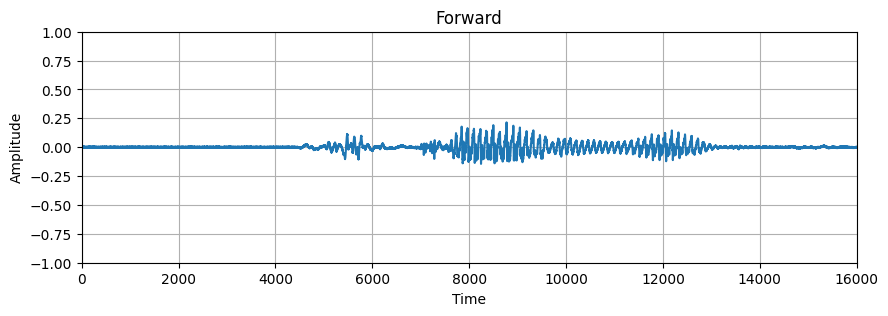

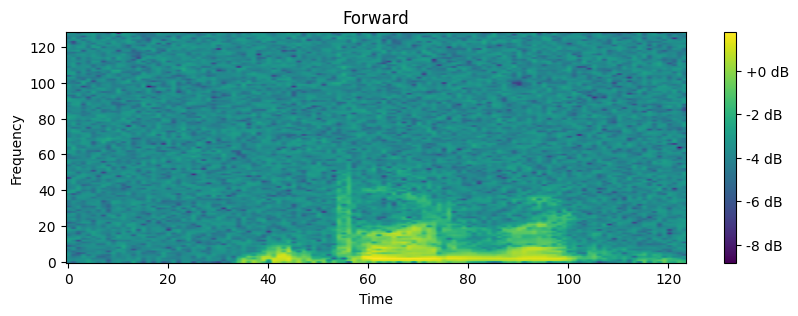

In [10]:
# Plot the waveform
def plot_wave(waveform, label):
    plt.figure(figsize=(10, 3))
    plt.title(label)
    plt.plot(waveform)
    plt.xlim([0, 16000])
    plt.ylim([-1, 1])
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid(True)

# Convert waveform to spectrogram
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram[..., tf.newaxis]

# Plot the spectrogram
def plot_spectrogram(spectrogram, label):
    spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    plt.figure(figsize=(10, 3))
    plt.title(label)
    plt.imshow(log_spec, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Plotting the waveform and the spectrogram of a random sample
audio, label = next(iter(training_set))

# Plot the wave with its label name
plot_wave(audio[0], label_names[label[0]])

# Plot the spectrogram with its label name
plot_spectrogram(get_spectrogram(audio[0]), label_names[label[0]])

In [11]:
def get_spectrogram_dataset(dataset):
    dataset = dataset.map(
        lambda x, y: (get_spectrogram(x), y),
        num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Applying spectrogram on the audio dataset
train_set = get_spectrogram_dataset(training_set)
validation_set = get_spectrogram_dataset(validation_set)

In [12]:
next(iter(train_set))[0].shape # batch of 16, each having [124,129,1] spectrumOutput

TensorShape([16, 124, 129, 1])

In [13]:
# dimension reduction, audio is [124,129,1] to be reduced to [64,64,1]
resizing_layer = tf.keras.layers.Resizing(64, 64)
def DimReduceAudio(audio, labels):
  new_audio = resizing_layer(audio)
  return new_audio, labels

# Applying the function on the dataset obtained from previous step
train_set = train_set.map(DimReduceAudio, tf.data.AUTOTUNE)
validation_set = validation_set.map(DimReduceAudio, tf.data.AUTOTUNE)

In [14]:
# normalise the audio spectrogram
normalise_layer = tf.keras.layers.Normalization()
def NormaliseAudio(audio, labels):
  new_audio = normalise_layer(audio)
  return new_audio, labels

# Applying the function on the dataset obtained from previous step
train_set = train_set.map(NormaliseAudio, tf.data.AUTOTUNE)
validation_set = validation_set.map(NormaliseAudio, tf.data.AUTOTUNE)

In [15]:
next(iter(train_set))[0].shape # batch of 16, each having [64,64,1] dimreduced_spectrumOutput

TensorShape([16, 64, 64, 1])

Pre-processing over. Now split the validation_set -> 50% test, 50% val

In [16]:
# Dividing validation set into two equal val and test set
val_set = validation_set.take(validation_set.cardinality() // 2)
test_set = validation_set.skip(validation_set.cardinality() // 2)

In [17]:
print("Train set shape:", train_set.element_spec[0].shape)
print("Validation set shape:", val_set.element_spec[0].shape)
print("Testing set shape:", test_set.element_spec[0].shape)

Train set shape: (None, 64, 64, 1)
Validation set shape: (None, 64, 64, 1)
Testing set shape: (None, 64, 64, 1)


Model definition and training

In [18]:
# Defining the model
def get_model_0(input_shape, num_labels): # this uses 2 2d conv with 64,128 kernals -> ann 256 neurons -> ann 3 neurons.
	model = tf.keras.Sequential([
		tf.keras.layers.Input(shape=input_shape), #input is [64,64,1]

		# Convolution layers followed by MaxPooling layer
		tf.keras.layers.Conv2D(64, 3, activation='relu'),
		tf.keras.layers.Conv2D(128, 3, activation='relu'),
		tf.keras.layers.MaxPooling2D(),
		tf.keras.layers.Dropout(0.5),
		tf.keras.layers.Flatten(),

		# Dense layer
		tf.keras.layers.Dense(256, activation='relu'),
		tf.keras.layers.Dropout(0.5),

		# Softmax layer to get the label prediction
		tf.keras.layers.Dense(num_labels, activation='softmax')
	])
	return model

def get_model_1(input_shape, num_labels): # this uses 2 2d conv with 8,16 kernals -> ann 3 neurons
	model = tf.keras.Sequential([
		tf.keras.layers.Input(shape=input_shape), #input is [64,64,1]

		# Convolution layers followed by MaxPooling layer
		tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu'),
		tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
		tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu'),
		tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
		tf.keras.layers.Dropout(0.5),

		tf.keras.layers.Flatten(),

		# Softmax layer to get the label prediction
		tf.keras.layers.Dense(num_labels, activation='softmax')
	])
	return model

def get_model_2(input_shape, num_labels): # this uses 2 1d conv with 8,16 kernals -> ann 3 neurons
	model = tf.keras.Sequential([
		tf.keras.layers.Input(shape=input_shape), #input is [64,64,1]

		# Convolution layers followed by MaxPooling layer
		tf.keras.layers.Conv1D(8, kernel_size=3, activation='relu'),
		tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
		tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu'),
		tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
		tf.keras.layers.Dropout(0.5),

		tf.keras.layers.Flatten(),

		# Softmax layer to get the label prediction
		tf.keras.layers.Dense(num_labels, activation='softmax')
	])
	return model

def get_model_3(input_shape, num_labels): # this uses ann 64 neurons -> ann 3 neurons
	model = tf.keras.Sequential([
		tf.keras.layers.Input(shape=input_shape), #input is [64,64,1]

		tf.keras.layers.Flatten(),

		# hidden layer
		tf.keras.layers.Dense(64, activation='relu'),

		# Softmax layer to get the label prediction
		tf.keras.layers.Dense(num_labels, activation='softmax')
	])
	return model

def get_model_4(input_shape, num_labels): # this uses 2 hidden layers ann 64 neurons -> ann 8 neurons -> ann 3 neurons
	model = tf.keras.Sequential([
		tf.keras.layers.Input(shape=input_shape), #input is [64,64,1]

		tf.keras.layers.Flatten(),

		# hidden layer
		tf.keras.layers.Dense(64, activation='relu'),
		tf.keras.layers.Dropout(0.5),

		tf.keras.layers.Dense(8, activation='relu'),

		# Softmax layer to get the label prediction
		tf.keras.layers.Dense(num_labels, activation='softmax')
	])
	return model

In [19]:
# Getting input shape from the sample audio and number of classes
input_shape = next(iter(train_set))[0][0].shape
print("Input shape:", input_shape)
num_labels = len(label_names)

Input shape: (64, 64, 1)


In [20]:
# Creating a model0 - 2 2d conv with 64,128 kernals -> ann 256 neurons -> ann 3 neurons
model_0 = get_model_0(input_shape, num_labels)
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 30, 128)       0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

In [21]:
# Creating a model1 - 2 2d conv with 8,16 kernals -> ann 3 neurons
model_1 = get_model_1(input_shape, num_labels)
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 8)         80        
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 8)         0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 31, 31, 8)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 16)        1168      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 16)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 16)       

In [22]:
# Creating a model2 - uses 2 1d conv with 8,16 kernals -> ann 3 neurons
model_2 = get_model_2(input_shape, num_labels)
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 64, 62, 8)         32        
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 31, 8)         0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 32, 31, 8)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 29, 16)        400       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 15, 16)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 16, 15, 16)       

In [23]:
# Creating a model3 - uses ann 64 neurons -> ann 3 neurons
model_3 = get_model_3(input_shape, num_labels)
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 4096)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                262208    
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 262403 (1.00 MB)
Trainable params: 262403 (1.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# Creating a model4 - 2 hidden layers ann 64 neurons -> ann 8 neurons -> ann 3 neurons
model_4 = get_model_4(input_shape, num_labels)
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 4096)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                262208    
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 8)                 520       
                                                                 
 dense_8 (Dense)             (None, 3)                 27        
                                                                 
Total params: 262755 (1.00 MB)
Trainable params: 262755 (1.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
#compile models
model_0.compile(
	optimizer=tf.keras.optimizers.Adam(),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(),
	metrics=['accuracy'],
)
model_1.compile(
	optimizer=tf.keras.optimizers.Adam(),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(),
	metrics=['accuracy'],
)
model_2.compile(
	optimizer=tf.keras.optimizers.Adam(),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(),
	metrics=['accuracy'],
)
model_3.compile(
	optimizer=tf.keras.optimizers.Adam(),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(),
	metrics=['accuracy'],
)
model_4.compile(
	optimizer=tf.keras.optimizers.Adam(),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(),
	metrics=['accuracy'],
)

In [26]:
# train models
EPOCHS = 10

print("Training model-0")
history_0 = model_0.fit(
	train_set,
	validation_data=val_set,
	epochs=EPOCHS,
)

print("Training model-1")
history_1 = model_1.fit(
	train_set,
	validation_data=val_set,
	epochs=EPOCHS,
)

print("Training model-2")
history_2 = model_2.fit(
	train_set,
	validation_data=val_set,
	epochs=EPOCHS,
)

print("Training model-3")
history_3 = model_3.fit(
	train_set,
	validation_data=val_set,
	epochs=EPOCHS,
)

print("Training model-4")
history_4 = model_4.fit(
	train_set,
	validation_data=val_set,
	epochs=EPOCHS,
)

Training model-0
Epoch 1/10
45/45 [==============================] - 14s 34ms/step - loss: 0.8046 - accuracy: 0.6792 - val_loss: 0.2511 - val_accuracy: 0.9271
Epoch 2/10
45/45 [==============================] - 1s 30ms/step - loss: 0.2817 - accuracy: 0.9125 - val_loss: 0.1181 - val_accuracy: 0.9583
Epoch 3/10
45/45 [==============================] - 2s 52ms/step - loss: 0.1166 - accuracy: 0.9597 - val_loss: 0.1205 - val_accuracy: 0.9688
Epoch 4/10
45/45 [==============================] - 3s 53ms/step - loss: 0.0928 - accuracy: 0.9694 - val_loss: 0.0810 - val_accuracy: 0.9792
Epoch 5/10
45/45 [==============================] - 2s 33ms/step - loss: 0.0546 - accuracy: 0.9847 - val_loss: 0.1257 - val_accuracy: 0.9479
Epoch 6/10
45/45 [==============================] - 1s 31ms/step - loss: 0.0527 - accuracy: 0.9819 - val_loss: 0.1184 - val_accuracy: 0.9792
Epoch 7/10
45/45 [==============================] - 1s 32ms/step - loss: 0.0244 - accuracy: 0.9944 - val_loss: 0.1971 - val_accuracy: 0.

History of model-0
6/6 [==============================] - 1s 37ms/step


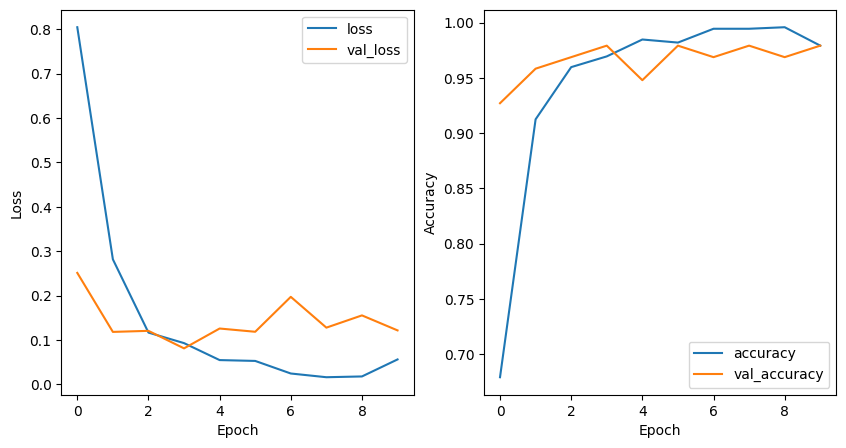

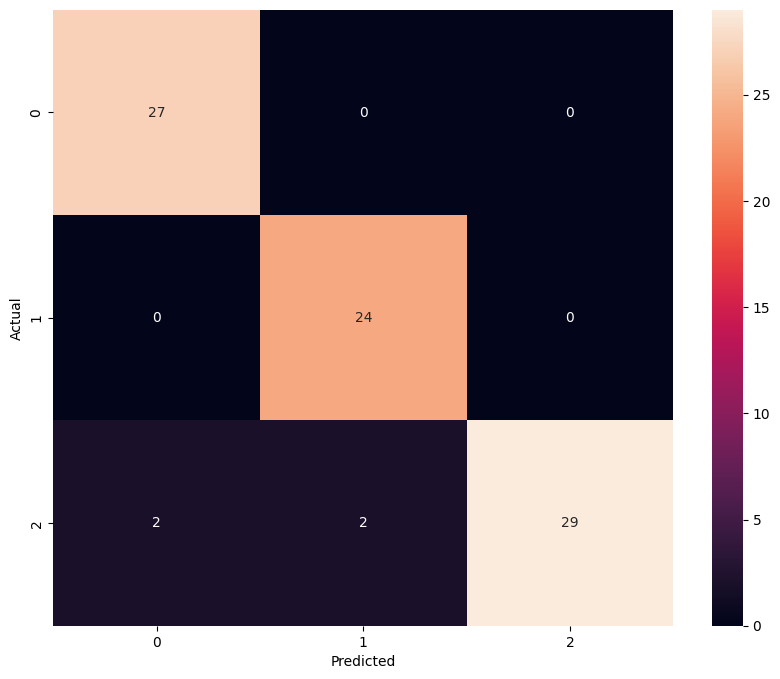

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       0.92      1.00      0.96        24
           2       1.00      0.88      0.94        33

    accuracy                           0.95        84
   macro avg       0.95      0.96      0.95        84
weighted avg       0.96      0.95      0.95        84

History of model-1
6/6 [==============================] - 0s 19ms/step


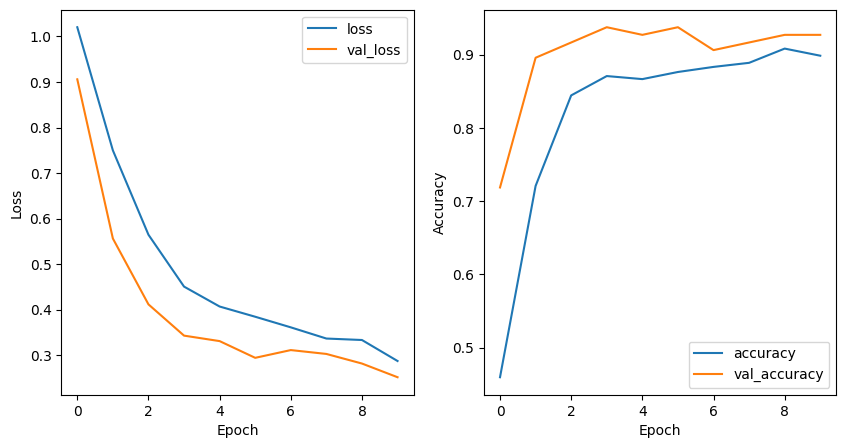

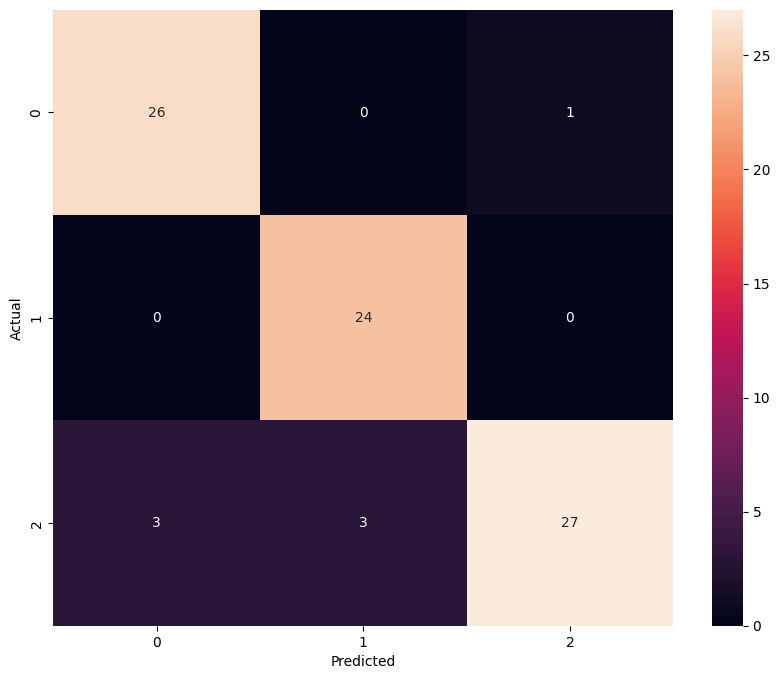

              precision    recall  f1-score   support

           0       0.90      0.96      0.93        27
           1       0.89      1.00      0.94        24
           2       0.96      0.82      0.89        33

    accuracy                           0.92        84
   macro avg       0.92      0.93      0.92        84
weighted avg       0.92      0.92      0.92        84

History of model-2
6/6 [==============================] - 0s 24ms/step


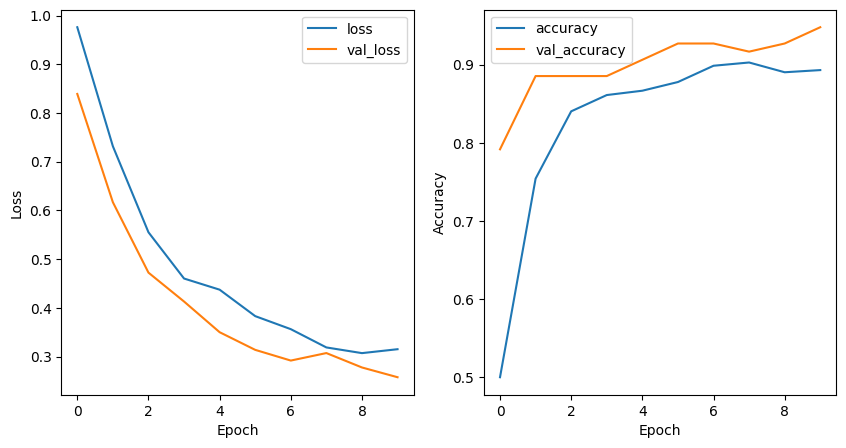

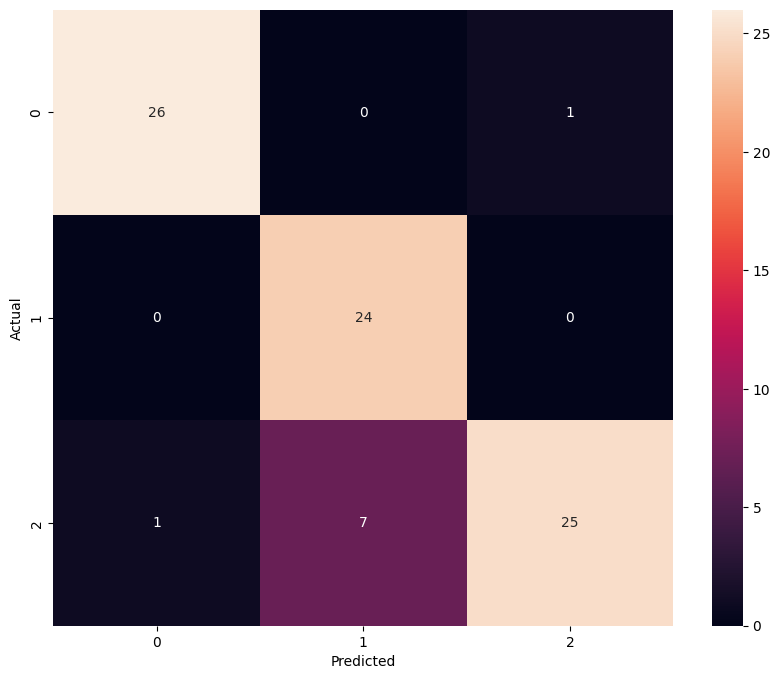

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        27
           1       0.77      1.00      0.87        24
           2       0.96      0.76      0.85        33

    accuracy                           0.89        84
   macro avg       0.90      0.91      0.89        84
weighted avg       0.91      0.89      0.89        84

History of model-3
6/6 [==============================] - 1s 22ms/step


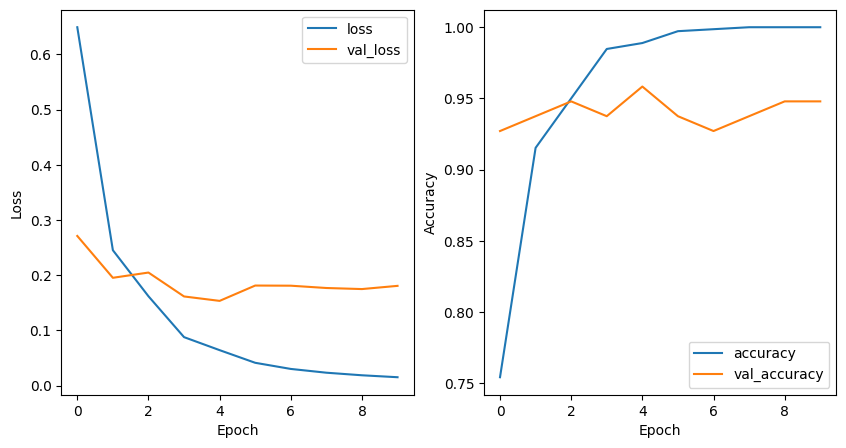

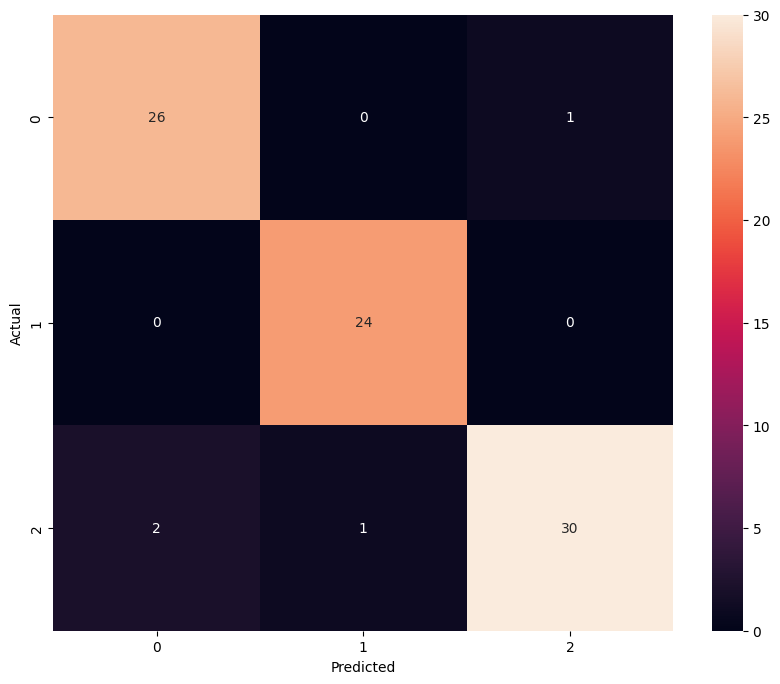

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        27
           1       0.96      1.00      0.98        24
           2       0.97      0.91      0.94        33

    accuracy                           0.95        84
   macro avg       0.95      0.96      0.95        84
weighted avg       0.95      0.95      0.95        84

History of model-4
6/6 [==============================] - 0s 16ms/step


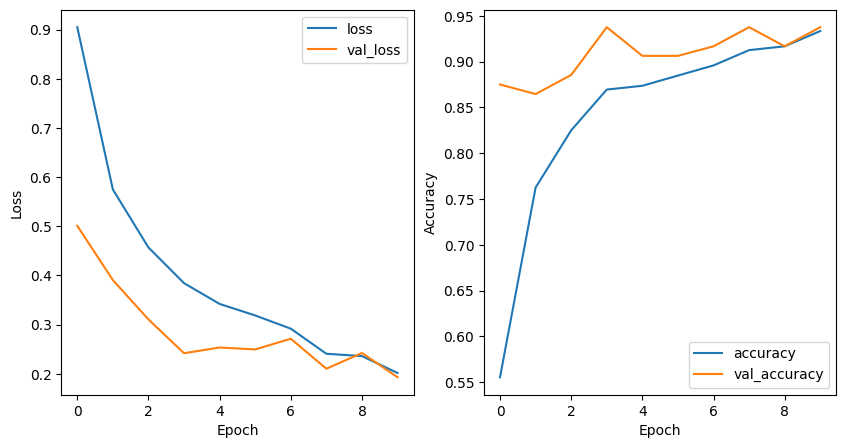

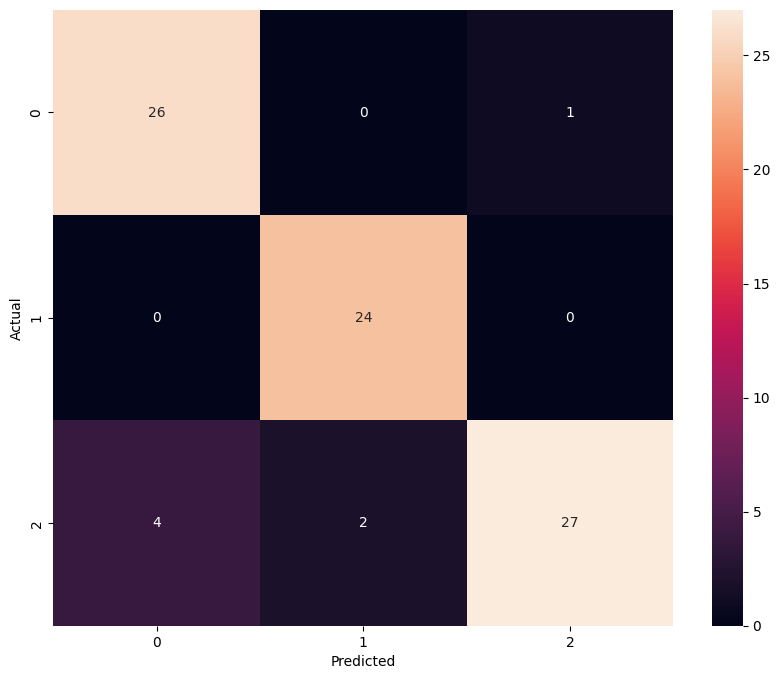

              precision    recall  f1-score   support

           0       0.87      0.96      0.91        27
           1       0.92      1.00      0.96        24
           2       0.96      0.82      0.89        33

    accuracy                           0.92        84
   macro avg       0.92      0.93      0.92        84
weighted avg       0.92      0.92      0.92        84



In [27]:
# Plotting the history of model_1
def plot_history(model_history,model_):
  metrics = model_history.history
  plt.figure(figsize=(10, 5))

  # Plotting training and validation loss
  plt.subplot(1, 2, 1)
  plt.plot(model_history.epoch, metrics['loss'], metrics['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  # Plotting training and validation accuracy
  plt.subplot(1, 2, 2)
  plt.plot(model_history.epoch, metrics['accuracy'], metrics['val_accuracy'])
  plt.legend(['accuracy', 'val_accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

  # Confusion matrix
  y_pred = np.argmax(model_.predict(test_set), axis=1)
  y_true = np.concatenate([y for x, y in test_set], axis=0)
  cm = tf.math.confusion_matrix(y_true, y_pred)

  # Plotting the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()
  report = classification_report(y_true, y_pred)
  print(report)

print("History of model-0")
plot_history(history_0,model_0)

print("History of model-1")
plot_history(history_1,model_1)

print("History of model-2")
plot_history(history_2,model_2)

print("History of model-3")
plot_history(history_3,model_3)

print("History of model-4")
plot_history(history_4,model_4)

Training model-SC
Epoch 1/50
45/45 [==============================] - 2s 25ms/step - loss: 1.0120 - accuracy: 0.5111 - val_loss: 0.8658 - val_accuracy: 0.7708
Epoch 2/50
45/45 [==============================] - 1s 30ms/step - loss: 0.7325 - accuracy: 0.7333 - val_loss: 0.5771 - val_accuracy: 0.9062
Epoch 3/50
45/45 [==============================] - 2s 37ms/step - loss: 0.5395 - accuracy: 0.8181 - val_loss: 0.4082 - val_accuracy: 0.9479
Epoch 4/50
45/45 [==============================] - 2s 46ms/step - loss: 0.4665 - accuracy: 0.8667 - val_loss: 0.3737 - val_accuracy: 0.9271
Epoch 5/50
45/45 [==============================] - 2s 47ms/step - loss: 0.4036 - accuracy: 0.8750 - val_loss: 0.3537 - val_accuracy: 0.9271
Epoch 6/50
45/45 [==============================] - 1s 26ms/step - loss: 0.3801 - accuracy: 0.8903 - val_loss: 0.3147 - val_accuracy: 0.9271
Epoch 7/50
45/45 [==============================] - 1s 26ms/step - loss: 0.3470 - accuracy: 0.8944 - val_loss: 0.3556 - val_accuracy: 0.

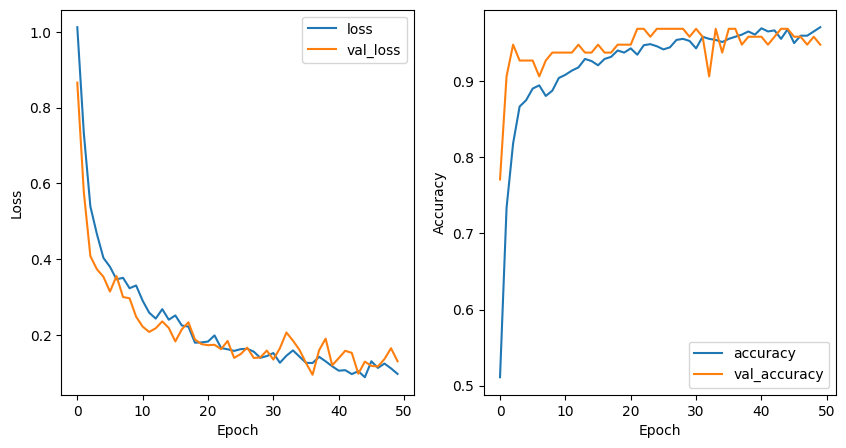

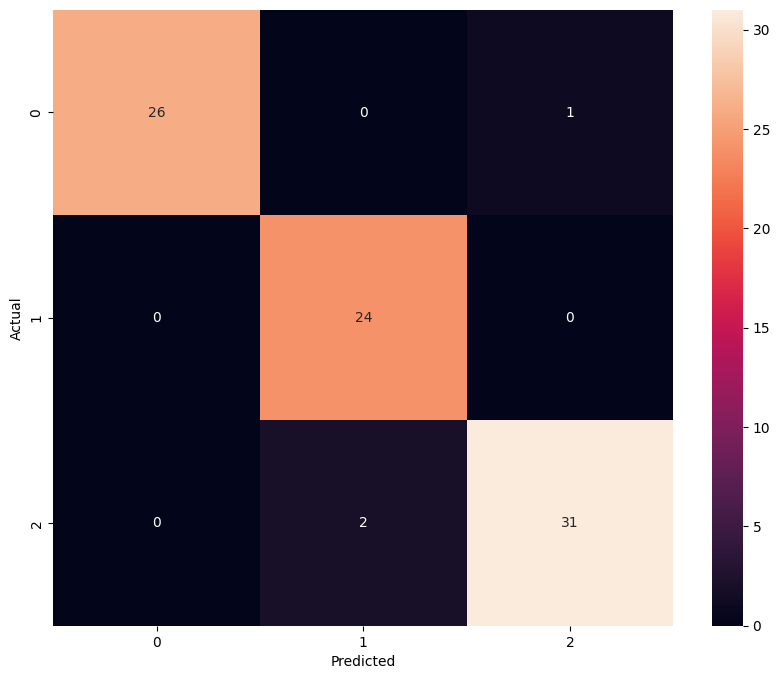

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        27
           1       0.92      1.00      0.96        24
           2       0.97      0.94      0.95        33

    accuracy                           0.96        84
   macro avg       0.96      0.97      0.96        84
weighted avg       0.97      0.96      0.96        84



In [28]:
# train Model_1 for deploying target = Arduino nano 33 (ARM Cortex-M4)
SC_model = get_model_1(input_shape, num_labels)
SC_model.compile(
	optimizer=tf.keras.optimizers.Adam(),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(),
	metrics=['accuracy'],
)

print("Training model-SC")
history_SC = SC_model.fit(
	train_set,
	validation_data=val_set,
	epochs=50,
)

print("History of model-SC newly trained")
plot_history(history_SC,SC_model)

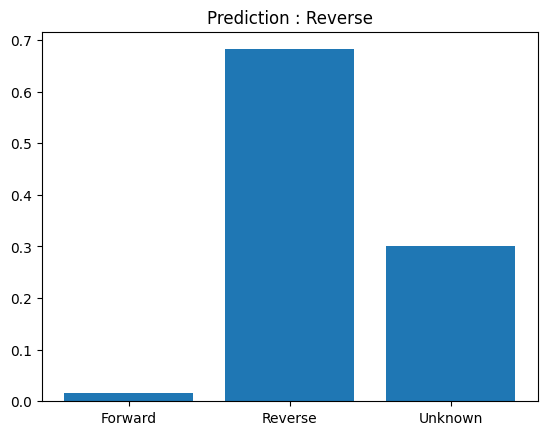

In [29]:
# inferencing the model_1
path1 = 'test1.wav'

def infer_model_1(path,):
  Input = tf.io.read_file(str(path))
  x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=16000,)
  audio, labels = squeeze(x, 'yes')
  display.display(display.Audio(audio, rate=16000))

  x = get_spectrogram(audio)

  resizing_layer = tf.keras.layers.Resizing(64, 64)
  x = resizing_layer(x)

  x = normalise_layer(x)

  #x = tf.expand_dims(x, axis=0)

  prediction = SC_model(x)
  plt.bar(label_names, prediction[0])
  plt.title('Prediction : '+label_names[np.argmax(prediction, axis=1).item()])
  plt.show()

infer_model_1(path1)

In [30]:
SC_model.save("SpeechClassifier_model.keras")
# SC_model = tf.keras.models.load_model("SpeechClassifier_model.keras")

For resource constrain computers - need tflite model

In [31]:
Repr_set=validation_set.unbatch() # create a representative dataset

def representative_dataset_gen():
    for element in Repr_set.take(100):
        inputTensor = tf.expand_dims(element[0], axis=0)
        yield [inputTensor]

converter = tf.lite.TFLiteConverter.from_keras_model(SC_model)

# Generate a smaller size .tflite model
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.representative_dataset = representative_dataset_gen
tflite_SC_model = converter.convert()
open("SC_LiteModel.tflite", "wb").write(tflite_SC_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


16536

In [32]:
# dataset for tflite model accuray checking
partial_dataset = train_set.take(100+16-1) # Take the necessary number of batches to get at least 100 elements (total_elements + batch_size - 1)
partial_dataset = partial_dataset.unbatch()

# Take the 100 elements
sample_dataset = partial_dataset.take(100)
sample_dataset=sample_dataset.batch(100)


In [33]:
audio_sample,label_sample = next(iter(sample_dataset))
print(audio_sample.shape)
print(label_sample.shape)

(100, 64, 64, 1)
(100,)


In [34]:
# interpret and get its accuracy
interpreter = tf.lite.Interpreter(model_path="SC_LiteModel.tflite")

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.allocate_tensors()

match_count=0
for i in range(100):
  interpreter.set_tensor(input_details[0]["index"], tf.expand_dims(audio_sample[i], axis=0))
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]["index"])
  label_output= np.argmax(output_data, axis=None, out=None)
  if label_sample[i].numpy() == label_output :
    match_count=match_count+1

print("Accuracy = ",match_count," %")

Accuracy =  85  %


Lets try tflite without much optimisation

In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(SC_model)
tflite_SC_model = converter.convert()
open("SC_LiteModel_notOpt.tflite", "wb").write(tflite_SC_model)

51244

In [36]:
# interpret and get its accuracy
interpreter = tf.lite.Interpreter(model_path="SC_LiteModel_notOpt.tflite")

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.allocate_tensors()

match_count=0
for i in range(100):
  interpreter.set_tensor(input_details[0]["index"], tf.expand_dims(audio_sample[i], axis=0))
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]["index"])
  label_output= np.argmax(output_data, axis=None, out=None)
  if label_sample[i].numpy() == label_output :
    match_count=match_count+1

print("Accuracy = ",match_count," %")

Accuracy =  99  %


In [37]:
import binascii

def convert_to_c_array(bytes) -> str:
  hexstr = binascii.hexlify(bytes).decode("UTF-8")
  hexstr = hexstr.upper()
  array = ["0x" + hexstr[i:i + 2] for i in range(0, len(hexstr), 2)]
  array = [array[i:i+10] for i in range(0, len(array), 10)]
  return ",\n  ".join([", ".join(e) for e in array])

tflite_binary = open("SC_LiteModel_notOpt.tflite", 'rb').read()
ascii_bytes = convert_to_c_array(tflite_binary)
c_file = "const unsigned char tf_model[] = {\n  " + ascii_bytes + "\n};\nunsigned int tf_model_len = " + str(len(tflite_binary)) + ";"
# print(c_file)
open("SC_LiteModel_toDeploy.h", "w").write(c_file)

317785

Done. Shall deploy this tflite model into Arduino Nano 33 BLE board. And do inferencing.